In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
from sklearn.cluster import DBSCAN, KMeans


        
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae

import tensorflow as tf
import tensorflow_addons as tfa

/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv
/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv")
original = pd.read_csv("/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv")

In [3]:
train

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...,...
5402,5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


In [4]:
original

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [5]:
cols = train.columns.tolist()
cols.remove('id')
cols

['CementComponent',
 'BlastFurnaceSlag',
 'FlyAshComponent',
 'WaterComponent',
 'SuperplasticizerComponent',
 'CoarseAggregateComponent',
 'FineAggregateComponent',
 'AgeInDays',
 'Strength']

In [6]:
original['CementComponent'] = original['CementComponent ']

In [7]:
train_df = pd.concat([train.copy(),original.copy()],ignore_index=True)

In [8]:
train_df

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,CementComponent
0,0.0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,NaN
1,1.0,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,NaN
2,2.0,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,NaN
3,3.0,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,NaN
4,4.0,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6432,NaN,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,276.4
6433,NaN,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,322.2
6434,NaN,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,148.5
6435,NaN,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,159.1


In [9]:
train_df.columns

Index(['id', 'CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength', 'CementComponent '],
      dtype='object')

In [10]:
train_df = train_df[~train_df.duplicated(subset=cols)]
train_df

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,CementComponent
0,0.0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,NaN
1,1.0,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,NaN
2,2.0,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,NaN
3,3.0,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,NaN
4,4.0,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6432,NaN,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,276.4
6433,NaN,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,322.2
6434,NaN,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,148.5
6435,NaN,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,159.1


In [11]:
def fe(df):
        #df['sum'] = df['CementComponent'] * df['FlyAshComponent'] * df['WaterComponent'] + df['SuperplasticizerComponent'] + df['CoarseAggregateComponent'] + df['FineAggregateComponent']
        df[['BlastSlugT','BlastSlugF','FlyAshT','FlyAshF','SuperplasticizerT','SuperplasticizerF']]=0
        df.loc[df['BlastFurnaceSlag']  <= 0.0, ['BlastSlugT']] = 1
        df.loc[df['BlastFurnaceSlag']  > 0.0, ['BlastSlugF']] = 1
        df.loc[df['FlyAshComponent']  <= 0.0, ['FlyAshT']] = 1
        df.loc[df['FlyAshComponent']  > 0.0, ['FlyAshF']] = 1
        df.loc[df['SuperplasticizerComponent']  <= 0.0, ['SuperplasticizerT']] = 1
        df.loc[df['SuperplasticizerComponent']  > 0.0, ['SuperplasticizerF']] = 1
        
        return df

In [12]:
TrainDF = train_df.copy().drop(['id','CementComponent '],axis=1)
TrainDF = fe(TrainDF)
#TrainDF = pd.get_dummies(TrainDF, columns=[])

TrainDF

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,BlastSlugT,BlastSlugF,FlyAshT,FlyAshF,SuperplasticizerT,SuperplasticizerF
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1,0,1,0,1,0
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,0,1,0,1,0,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,0,1,1,0,1,0
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,0,1,1,0,1,0
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0,1,0,1,0,1
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,1,0,0,1,0,1
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0,1,0,1,0,1
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0,1,1,0,0,1


In [13]:
TestDF = test.copy().drop(['id'],axis=1)
TestDF = fe(TestDF)
#TestDF = pd.get_dummies(TestDF, columns=[])
TestDF

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,BlastSlugT,BlastSlugF,FlyAshT,FlyAshF,SuperplasticizerT,SuperplasticizerF
0,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56,0,1,0,1,0,1
1,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7,1,0,1,0,1,0
2,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28,1,0,1,0,1,0
3,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100,1,0,0,1,0,1
4,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3600,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28,0,1,0,1,0,1
3601,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28,1,0,1,0,1,0
3602,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28,0,1,1,0,0,1
3603,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,0,1,1,0,0,1


In [14]:
X = TrainDF.drop(['Strength'], axis=1)
y = TrainDF.Strength
X_test = TestDF

In [15]:
pip install -q lightgbm

Note: you may need to restart the kernel to use updated packages.


In [16]:
import catboost
from catboost import Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm.sklearn import LGBMRegressor

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [18]:
def objectiveCat(trial):
    model = catboost.CatBoostRegressor(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test1)
    return mean_squared_error(y_test, y_pred)

def objectiveXgb(trial):
    model = XGBRegressor(
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        max_depth=trial.suggest_int("max_depth", 4, 10),
        eval_metric='rmse',
        objective='reg:squarederror',
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test1)
    return mean_squared_error(y_test, y_pred)

def objectiveLgb(trial):
    model = lgbm.LGBMRegressor(
                       objective='regression',
                       learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
                       max_depth=trial.suggest_int("max_depth", 4, 10),
                       num_leaves=trial.suggest_int("num_leaves", 20, 200),
#                       'colsample_bytree': 0.8,
#                        'subsample': 0.9,
#                        'subsample_freq': 5,
                       metric='RMSE',
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test1)
    return mean_squared_error(y_test, y_pred)

In [19]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_wine
import optuna
from optuna.samplers import TPESampler
import catboost
import pickle

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
studyCat = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
studyCat.optimize(objectiveCat, n_trials=500)

In [20]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
studyXgb = optuna.create_study(study_name="xgbboost", direction="maximize", sampler=sampler)
studyXgb.optimize(objectiveXgb, n_trials=500)

In [21]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
studyLgb = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
studyLgb.optimize(objectiveLgb, n_trials=500)

In [22]:
studyCat.best_params

{'iterations': 101,
 'learning_rate': 0.001002609438338019,
 'depth': 4,
 'l2_leaf_reg': 98.80234131036585,
 'bootstrap_type': 'Bayesian',
 'random_strength': 7.67607803104154e-05,
 'bagging_temperature': 7.131746682640162,
 'od_type': 'IncToDec',
 'od_wait': 38}

In [23]:
studyXgb.best_params

{'learning_rate': 0.0010000170362051387, 'max_depth': 8}

In [24]:
studyLgb.best_params

{'learning_rate': 0.0010000049373642744, 'max_depth': 4, 'num_leaves': 184}

In [25]:


n_folds = 15

MAX_ITER = 15000
PATIENCE = 1000
DISPLAY_FREQ = 300

eval_predsCB = []
predsCB = []

k_fold = KFold(n_splits=n_folds, random_state=42, shuffle=True)

MODEL_PARAMS = {
**studyCat.best_params,
                    'eval_metric': 'RMSE',
                'verbose': 1500,
    'iterations': MAX_ITER,
    #'verbose':False
               }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = catboost.CatBoostRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          metric_period = DISPLAY_FREQ
         )
    #predCB =  norm_0to1(np.squeeze(np.mean(predCB, axis=0)))
    predsCB.append(model.predict(X_test))

#model.get_feature_importance(Pool(X, y), type="PredictionValuesChange")

0:	learn: 16.4205571	test: 15.7498261	best: 15.7498261 (0)	total: 1.47ms	remaining: 22.1s
1500:	learn: 13.0799038	test: 12.3803213	best: 12.3803213 (1500)	total: 1.65s	remaining: 14.8s
3000:	learn: 12.2968948	test: 11.5585901	best: 11.5585901 (3000)	total: 3.26s	remaining: 13s
4500:	learn: 12.0129148	test: 11.2337695	best: 11.2337695 (4500)	total: 4.9s	remaining: 11.4s
6000:	learn: 11.8705606	test: 11.0740414	best: 11.0740414 (6000)	total: 6.53s	remaining: 9.8s
7500:	learn: 11.7908340	test: 10.9839271	best: 10.9839271 (7500)	total: 8.15s	remaining: 8.15s
9000:	learn: 11.7383593	test: 10.9268100	best: 10.9268061 (8999)	total: 9.78s	remaining: 6.52s
10500:	learn: 11.6964515	test: 10.8894029	best: 10.8894029 (10500)	total: 11.4s	remaining: 4.89s
12000:	learn: 11.6637000	test: 10.8627144	best: 10.8627144 (12000)	total: 13.1s	remaining: 3.27s
13500:	learn: 11.6365008	test: 10.8437222	best: 10.8437222 (13500)	total: 14.7s	remaining: 1.63s
14999:	learn: 11.6125975	test: 10.8273298	best: 10.82

1500:	learn: 13.0226499	test: 13.2595650	best: 13.2595650 (1500)	total: 1.64s	remaining: 14.7s
3000:	learn: 12.2183234	test: 12.5942010	best: 12.5942010 (3000)	total: 3.37s	remaining: 13.5s
4500:	learn: 11.9264037	test: 12.3707652	best: 12.3707652 (4500)	total: 5.24s	remaining: 12.2s
6000:	learn: 11.7800388	test: 12.2714679	best: 12.2714679 (6000)	total: 6.89s	remaining: 10.3s
7500:	learn: 11.6979045	test: 12.2233851	best: 12.2233851 (7500)	total: 8.49s	remaining: 8.49s
9000:	learn: 11.6398941	test: 12.1953126	best: 12.1953126 (9000)	total: 10.1s	remaining: 6.73s
10500:	learn: 11.5960138	test: 12.1792593	best: 12.1792593 (10500)	total: 11.7s	remaining: 5.03s
12000:	learn: 11.5615913	test: 12.1701474	best: 12.1701474 (12000)	total: 13.4s	remaining: 3.34s
13500:	learn: 11.5332125	test: 12.1639104	best: 12.1638837 (13494)	total: 15s	remaining: 1.67s
14999:	learn: 11.5088423	test: 12.1605454	best: 12.1604594 (14959)	total: 16.7s	remaining: 0us

bestTest = 12.16045938
bestIteration = 14959


1500:	learn: 13.1101263	test: 12.0870203	best: 12.0870203 (1500)	total: 1.62s	remaining: 14.5s
3000:	learn: 12.3015694	test: 11.4038509	best: 11.4038509 (3000)	total: 3.22s	remaining: 12.9s
4500:	learn: 11.9994827	test: 11.2079422	best: 11.2079422 (4500)	total: 4.85s	remaining: 11.3s
6000:	learn: 11.8607444	test: 11.1454664	best: 11.1454430 (5998)	total: 6.47s	remaining: 9.7s
7500:	learn: 11.7766391	test: 11.1178853	best: 11.1178572 (7499)	total: 8.09s	remaining: 8.09s
9000:	learn: 11.7221956	test: 11.1053097	best: 11.1053097 (9000)	total: 9.71s	remaining: 6.47s
10500:	learn: 11.6800347	test: 11.0963492	best: 11.0963465 (10498)	total: 11.4s	remaining: 4.88s
12000:	learn: 11.6471486	test: 11.0905179	best: 11.0905179 (12000)	total: 13s	remaining: 3.25s
13500:	learn: 11.6193762	test: 11.0848332	best: 11.0848006 (13479)	total: 14.6s	remaining: 1.63s
14999:	learn: 11.5943449	test: 11.0776919	best: 11.0776473 (14993)	total: 16.3s	remaining: 0us

bestTest = 11.07764729
bestIteration = 14993



1500:	learn: 13.0579976	test: 13.0475788	best: 13.0475788 (1500)	total: 1.94s	remaining: 17.4s
3000:	learn: 12.2549623	test: 12.3112775	best: 12.3112775 (3000)	total: 3.57s	remaining: 14.3s
4500:	learn: 11.9577460	test: 12.0593147	best: 12.0593147 (4500)	total: 5.21s	remaining: 12.1s
6000:	learn: 11.8110564	test: 11.9452656	best: 11.9452348 (5997)	total: 6.82s	remaining: 10.2s
7500:	learn: 11.7279017	test: 11.8863893	best: 11.8863893 (7500)	total: 8.46s	remaining: 8.46s
9000:	learn: 11.6704748	test: 11.8475202	best: 11.8475202 (9000)	total: 10.1s	remaining: 6.74s
10500:	learn: 11.6288059	test: 11.8211047	best: 11.8211047 (10500)	total: 11.7s	remaining: 5.02s
12000:	learn: 11.5957596	test: 11.8052280	best: 11.8051864 (11997)	total: 13.4s	remaining: 3.34s
13500:	learn: 11.5680287	test: 11.7908935	best: 11.7908422 (13491)	total: 15.1s	remaining: 1.67s
14999:	learn: 11.5435713	test: 11.7792426	best: 11.7792157 (14991)	total: 16.7s	remaining: 0us

bestTest = 11.77921567
bestIteration = 1499

1500:	learn: 12.9968345	test: 13.7867134	best: 13.7867134 (1500)	total: 1.64s	remaining: 14.8s
3000:	learn: 12.2121859	test: 12.8604948	best: 12.8604948 (3000)	total: 3.31s	remaining: 13.2s
4500:	learn: 11.9300112	test: 12.4906473	best: 12.4906473 (4500)	total: 4.95s	remaining: 11.6s
6000:	learn: 11.7931902	test: 12.2985262	best: 12.2985262 (6000)	total: 6.63s	remaining: 9.94s
7500:	learn: 11.7134317	test: 12.1850158	best: 12.1850158 (7500)	total: 8.28s	remaining: 8.27s
9000:	learn: 11.6607378	test: 12.1132697	best: 12.1132697 (9000)	total: 9.95s	remaining: 6.63s
10500:	learn: 11.6212085	test: 12.0627093	best: 12.0627093 (10500)	total: 11.6s	remaining: 4.97s
12000:	learn: 11.5889938	test: 12.0247775	best: 12.0247775 (12000)	total: 13.3s	remaining: 3.31s
13500:	learn: 11.5611481	test: 11.9935242	best: 11.9935242 (13500)	total: 15s	remaining: 1.66s
14999:	learn: 11.5381822	test: 11.9708394	best: 11.9708394 (14999)	total: 16.8s	remaining: 0us

bestTest = 11.97083942
bestIteration = 14999


1500:	learn: 13.0891021	test: 12.3745998	best: 12.3745998 (1500)	total: 1.67s	remaining: 15s
3000:	learn: 12.2841968	test: 11.6924827	best: 11.6924827 (3000)	total: 3.38s	remaining: 13.5s
4500:	learn: 11.9867840	test: 11.4786296	best: 11.4786296 (4500)	total: 5.04s	remaining: 11.7s
6000:	learn: 11.8418742	test: 11.3938377	best: 11.3938377 (6000)	total: 6.69s	remaining: 10s
7500:	learn: 11.7621091	test: 11.3543742	best: 11.3543742 (7500)	total: 8.34s	remaining: 8.34s
9000:	learn: 11.7046086	test: 11.3257446	best: 11.3257446 (9000)	total: 9.99s	remaining: 6.66s
10500:	learn: 11.6645463	test: 11.3105335	best: 11.3105126 (10499)	total: 11.6s	remaining: 4.99s
12000:	learn: 11.6305693	test: 11.2954456	best: 11.2954285 (11998)	total: 13.3s	remaining: 3.32s
13500:	learn: 11.6030219	test: 11.2834808	best: 11.2834808 (13500)	total: 15s	remaining: 1.66s
14999:	learn: 11.5788358	test: 11.2734641	best: 11.2734641 (14999)	total: 16.6s	remaining: 0us

bestTest = 11.2734641
bestIteration = 14999

0:	l

1500:	learn: 13.0436902	test: 13.2418939	best: 13.2418939 (1500)	total: 1.62s	remaining: 14.6s
3000:	learn: 12.2510943	test: 12.4717680	best: 12.4717680 (3000)	total: 3.25s	remaining: 13s
4500:	learn: 11.9528712	test: 12.1883268	best: 12.1883268 (4500)	total: 4.86s	remaining: 11.3s
6000:	learn: 11.8103895	test: 12.0549261	best: 12.0549036 (5999)	total: 6.5s	remaining: 9.74s
7500:	learn: 11.7275134	test: 11.9779435	best: 11.9779435 (7500)	total: 8.15s	remaining: 8.15s
9000:	learn: 11.6718818	test: 11.9263170	best: 11.9263170 (9000)	total: 9.8s	remaining: 6.53s
10500:	learn: 11.6292789	test: 11.8882443	best: 11.8882443 (10500)	total: 11.5s	remaining: 4.91s
12000:	learn: 11.5957282	test: 11.8601134	best: 11.8601134 (12000)	total: 13.5s	remaining: 3.37s
13500:	learn: 11.5673341	test: 11.8360265	best: 11.8360250 (13499)	total: 15.1s	remaining: 1.68s
14999:	learn: 11.5430085	test: 11.8172275	best: 11.8172275 (14999)	total: 16.8s	remaining: 0us

bestTest = 11.8172275
bestIteration = 14999

0:

1500:	learn: 13.0215777	test: 13.7336656	best: 13.7336656 (1500)	total: 1.69s	remaining: 15.2s
3000:	learn: 12.2298088	test: 12.9151518	best: 12.9151518 (3000)	total: 3.33s	remaining: 13.3s
4500:	learn: 11.9271429	test: 12.6006366	best: 12.6006366 (4500)	total: 5s	remaining: 11.7s
6000:	learn: 11.7819099	test: 12.4522814	best: 12.4522814 (6000)	total: 6.65s	remaining: 9.97s
7500:	learn: 11.6963553	test: 12.3699590	best: 12.3699590 (7500)	total: 8.31s	remaining: 8.3s
9000:	learn: 11.6399055	test: 12.3209082	best: 12.3209082 (9000)	total: 9.96s	remaining: 6.64s
10500:	learn: 11.5979789	test: 12.2886500	best: 12.2886500 (10500)	total: 11.6s	remaining: 4.98s
12000:	learn: 11.5644233	test: 12.2643645	best: 12.2643634 (11998)	total: 13.3s	remaining: 3.32s
13500:	learn: 11.5355101	test: 12.2449951	best: 12.2449951 (13500)	total: 14.9s	remaining: 1.66s
14999:	learn: 11.5105589	test: 12.2297654	best: 12.2297481 (14997)	total: 16.6s	remaining: 0us

bestTest = 12.22974806
bestIteration = 14997

S

1500:	learn: 13.0458970	test: 13.0187178	best: 13.0187178 (1500)	total: 1.67s	remaining: 15s
3000:	learn: 12.2493171	test: 12.3172421	best: 12.3172421 (3000)	total: 3.34s	remaining: 13.4s
4500:	learn: 11.9489462	test: 12.0841600	best: 12.0841600 (4500)	total: 5.01s	remaining: 11.7s
6000:	learn: 11.8075409	test: 11.9897852	best: 11.9897852 (6000)	total: 6.71s	remaining: 10.1s
7500:	learn: 11.7235254	test: 11.9410361	best: 11.9410144 (7494)	total: 8.38s	remaining: 8.38s
9000:	learn: 11.6670012	test: 11.9118271	best: 11.9118271 (9000)	total: 10.2s	remaining: 6.78s
10500:	learn: 11.6247955	test: 11.8926738	best: 11.8926738 (10500)	total: 11.9s	remaining: 5.08s
12000:	learn: 11.5916677	test: 11.8777034	best: 11.8777034 (12000)	total: 13.5s	remaining: 3.38s
13500:	learn: 11.5631068	test: 11.8659042	best: 11.8659042 (13500)	total: 15.2s	remaining: 1.68s
14999:	learn: 11.5389544	test: 11.8564971	best: 11.8564918 (14991)	total: 16.9s	remaining: 0us

bestTest = 11.85649179
bestIteration = 14991


1500:	learn: 13.0004733	test: 13.7760102	best: 13.7760102 (1500)	total: 1.69s	remaining: 15.2s
3000:	learn: 12.2154623	test: 12.9684552	best: 12.9684552 (3000)	total: 3.35s	remaining: 13.4s
4500:	learn: 11.9245349	test: 12.6625951	best: 12.6625951 (4500)	total: 5.02s	remaining: 11.7s
6000:	learn: 11.7855337	test: 12.5122396	best: 12.5122396 (6000)	total: 6.71s	remaining: 10.1s
7500:	learn: 11.7049703	test: 12.4228712	best: 12.4228712 (7500)	total: 8.38s	remaining: 8.38s
9000:	learn: 11.6513040	test: 12.3596249	best: 12.3596244 (8998)	total: 10.1s	remaining: 6.73s
10500:	learn: 11.6105592	test: 12.3109127	best: 12.3109127 (10500)	total: 11.8s	remaining: 5.04s
12000:	learn: 11.5785059	test: 12.2719192	best: 12.2719192 (12000)	total: 13.4s	remaining: 3.36s
13500:	learn: 11.5506083	test: 12.2371992	best: 12.2371992 (13500)	total: 15.1s	remaining: 1.68s
14999:	learn: 11.5276861	test: 12.2110820	best: 12.2110820 (14999)	total: 16.8s	remaining: 0us

bestTest = 12.211082
bestIteration = 14999


1500:	learn: 13.0564565	test: 12.7464666	best: 12.7464666 (1500)	total: 1.68s	remaining: 15.1s
3000:	learn: 12.2573842	test: 12.0295931	best: 12.0295931 (3000)	total: 3.34s	remaining: 13.3s
4500:	learn: 11.9634391	test: 11.7947367	best: 11.7947367 (4500)	total: 5.02s	remaining: 11.7s
6000:	learn: 11.8222619	test: 11.6948120	best: 11.6948120 (6000)	total: 6.83s	remaining: 10.2s
7500:	learn: 11.7417992	test: 11.6434898	best: 11.6434898 (7500)	total: 8.6s	remaining: 8.59s
9000:	learn: 11.6849019	test: 11.6122622	best: 11.6122622 (9000)	total: 10.3s	remaining: 6.86s
10500:	learn: 11.6432907	test: 11.5910856	best: 11.5910445 (10497)	total: 11.9s	remaining: 5.12s
12000:	learn: 11.6092243	test: 11.5750708	best: 11.5750318 (11998)	total: 13.6s	remaining: 3.4s
13500:	learn: 11.5823565	test: 11.5652711	best: 11.5652664 (13494)	total: 15.3s	remaining: 1.7s
14999:	learn: 11.5588964	test: 11.5563043	best: 11.5563043 (14999)	total: 16.9s	remaining: 0us

bestTest = 11.55630427
bestIteration = 14999



1500:	learn: 13.0736798	test: 13.0059247	best: 13.0059247 (1500)	total: 1.64s	remaining: 14.7s
3000:	learn: 12.2915970	test: 12.0321929	best: 12.0321929 (3000)	total: 3.28s	remaining: 13.1s
4500:	learn: 12.0006181	test: 11.6496629	best: 11.6496629 (4500)	total: 4.95s	remaining: 11.5s
6000:	learn: 11.8594215	test: 11.4647718	best: 11.4647718 (6000)	total: 6.62s	remaining: 9.93s
7500:	learn: 11.7755262	test: 11.3572140	best: 11.3572140 (7500)	total: 8.32s	remaining: 8.32s
9000:	learn: 11.7180849	test: 11.2883428	best: 11.2883428 (9000)	total: 9.99s	remaining: 6.66s
10500:	learn: 11.6777848	test: 11.2464880	best: 11.2464597 (10498)	total: 11.7s	remaining: 5s
12000:	learn: 11.6435342	test: 11.2149142	best: 11.2149142 (12000)	total: 13.4s	remaining: 3.34s
13500:	learn: 11.6145197	test: 11.1899669	best: 11.1899669 (13500)	total: 15s	remaining: 1.67s
14999:	learn: 11.5897008	test: 11.1713843	best: 11.1713843 (14999)	total: 16.7s	remaining: 0us

bestTest = 11.17138431
bestIteration = 14999

0:

1500:	learn: 13.0663660	test: 12.8806796	best: 12.8806796 (1500)	total: 1.68s	remaining: 15.1s
3000:	learn: 12.2628985	test: 12.1211855	best: 12.1211855 (3000)	total: 3.6s	remaining: 14.4s
4500:	learn: 11.9677217	test: 11.8458769	best: 11.8458769 (4500)	total: 5.46s	remaining: 12.7s
6000:	learn: 11.8251840	test: 11.7160832	best: 11.7160832 (6000)	total: 7.14s	remaining: 10.7s
7500:	learn: 11.7416844	test: 11.6424876	best: 11.6424876 (7500)	total: 8.82s	remaining: 8.82s
9000:	learn: 11.6884523	test: 11.5967395	best: 11.5967395 (9000)	total: 10.5s	remaining: 6.99s
10500:	learn: 11.6472769	test: 11.5620426	best: 11.5620426 (10500)	total: 12.2s	remaining: 5.21s
12000:	learn: 11.6146468	test: 11.5380677	best: 11.5380667 (11999)	total: 13.9s	remaining: 3.47s
13500:	learn: 11.5874189	test: 11.5177685	best: 11.5177685 (13500)	total: 15.6s	remaining: 1.73s
14999:	learn: 11.5636582	test: 11.5003964	best: 11.5003964 (14999)	total: 17.2s	remaining: 0us

bestTest = 11.50039641
bestIteration = 14999

1500:	learn: 12.9933103	test: 13.9958870	best: 13.9958870 (1500)	total: 1.68s	remaining: 15.1s
3000:	learn: 12.1940482	test: 13.2017857	best: 13.2017857 (3000)	total: 3.34s	remaining: 13.3s
4500:	learn: 11.8934655	test: 12.9122870	best: 12.9122870 (4500)	total: 5s	remaining: 11.7s
6000:	learn: 11.7541408	test: 12.7904314	best: 12.7904314 (6000)	total: 6.73s	remaining: 10.1s
7500:	learn: 11.6709412	test: 12.7252063	best: 12.7252036 (7499)	total: 8.4s	remaining: 8.4s
9000:	learn: 11.6144432	test: 12.6859108	best: 12.6859108 (9000)	total: 10.1s	remaining: 6.71s
10500:	learn: 11.5711550	test: 12.6592139	best: 12.6592139 (10500)	total: 11.7s	remaining: 5.03s
12000:	learn: 11.5383278	test: 12.6414978	best: 12.6414673 (11998)	total: 13.4s	remaining: 3.35s
13500:	learn: 11.5102322	test: 12.6283641	best: 12.6283641 (13500)	total: 15.1s	remaining: 1.67s
14999:	learn: 11.4860966	test: 12.6198050	best: 12.6197935 (14969)	total: 16.8s	remaining: 0us

bestTest = 12.61979348
bestIteration = 14969

Sh

1500:	learn: 13.0604950	test: 12.7098172	best: 12.7098172 (1500)	total: 1.85s	remaining: 16.6s
3000:	learn: 12.2746047	test: 11.9899224	best: 11.9899224 (3000)	total: 3.52s	remaining: 14.1s
4500:	learn: 11.9745456	test: 11.7242582	best: 11.7242582 (4500)	total: 5.17s	remaining: 12.1s
6000:	learn: 11.8332817	test: 11.6041630	best: 11.6041630 (6000)	total: 6.83s	remaining: 10.2s
7500:	learn: 11.7504426	test: 11.5380975	best: 11.5380884 (7499)	total: 8.5s	remaining: 8.5s
9000:	learn: 11.6944803	test: 11.4967150	best: 11.4967150 (9000)	total: 10.2s	remaining: 6.79s
10500:	learn: 11.6537185	test: 11.4682828	best: 11.4682828 (10500)	total: 11.8s	remaining: 5.07s
12000:	learn: 11.6204296	test: 11.4470051	best: 11.4469665 (11981)	total: 13.5s	remaining: 3.37s
13500:	learn: 11.5922530	test: 11.4306512	best: 11.4306512 (13500)	total: 15.2s	remaining: 1.68s
14999:	learn: 11.5684665	test: 11.4182973	best: 11.4182906 (14975)	total: 16.8s	remaining: 0us

bestTest = 11.41829059
bestIteration = 14975


In [26]:


# n_folds = 20
k_fold = KFold(n_splits=n_folds, random_state=42, shuffle=True)

eval_predsXB = []
predsXB = []

PATIENCE = 200

MODEL_PARAMS = {
    **studyXgb.best_params,
            'eval_metric':'rmse',
        'objective':'reg:squarederror',
        'n_estimators': 20000, #1000, 5000
                       'colsample_bytree': 0.95, # 0.95
                       'subsample': 1,
                       'reg_lambda': 20,
                       'early_stopping_rounds': PATIENCE,
                       'eval_metric':'rmse',
#                        'tree_method': 'gpu_hist',
                'objective':'reg:squarederror',
                'booster':'gbtree',
                       'seed': 123
}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
          verbose = 1000,
         )
    predsXB.append(model.predict(X_test))
    #predsXB.append(norm_0to1(np.squeeze(np.mean(model.predict(X_test),axis=0))))
#     eval_predsXB.append(model.predict(X))

[0]	validation_0-rmse:37.98696
[1000]	validation_0-rmse:17.78453
[2000]	validation_0-rmse:12.19664
[3000]	validation_0-rmse:11.05243
[4000]	validation_0-rmse:10.80124
[5000]	validation_0-rmse:10.75460
[5132]	validation_0-rmse:10.76090
[0]	validation_0-rmse:38.34327
[1000]	validation_0-rmse:18.54790
[2000]	validation_0-rmse:13.46928
[3000]	validation_0-rmse:12.58329
[4000]	validation_0-rmse:12.44513
[4411]	validation_0-rmse:12.44270
[0]	validation_0-rmse:37.28944
[1000]	validation_0-rmse:17.56210
[2000]	validation_0-rmse:12.29478
[3000]	validation_0-rmse:11.33130
[4000]	validation_0-rmse:11.18091
[4504]	validation_0-rmse:11.18224
[0]	validation_0-rmse:37.87065
[1000]	validation_0-rmse:18.21139
[2000]	validation_0-rmse:13.19299
[3000]	validation_0-rmse:12.23346
[4000]	validation_0-rmse:12.14332
[4430]	validation_0-rmse:12.14247
[0]	validation_0-rmse:39.68700
[1000]	validation_0-rmse:19.32088
[2000]	validation_0-rmse:13.55661
[3000]	validation_0-rmse:12.19164
[4000]	validation_0-rmse:11.8

In [27]:


# n_folds = 20
k_fold = KFold(n_splits=n_folds, random_state=42, shuffle=True)

eval_predsLB = []
predsLB = []

MODEL_PARAMS = {
                       'objective':'regression',
**studyLgb.best_params,
#                       'colsample_bytree': 0.8,
#                        'subsample': 0.9,
#                        'subsample_freq': 5,
                       'min_child_samples': 36,
                       'reg_lambda': 28,
                       'n_estimators': 20000,
                       'metric': 'RMSE',
                       'random_state': 123
}

callbacks = [lgbm.early_stopping(100, verbose=1), #lgbm.log_evaluation(period=0)
]

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMRegressor(**MODEL_PARAMS)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
#           early_stopping_rounds = PATIENCE,
          callbacks=callbacks
         )
    predsLB.append(model.predict(X_test))
    #predsLB.append(norm_0to1(np.squeeze(np.mean(model.predict(X_test),axis=0))))
#     eval_predsLB.append(model.predict(X))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping, best iteration is:
[7708]	valid_0's rmse: 10.7019
Early stopping

In [28]:
def preds_plot(preds):
    plt.figure(figsize=(15, 7))
    plt.title('Distribution of predictions', 
          size=25, y=1.03, fontname='Calibri', 
          fontweight='bold', color='#444444')
    a = sns.histplot(preds, color='#72bfd6', bins=100)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)
    plt.show()

In [29]:
a = 0.35
b = 0.3
c = 0.35
#d = 0.2

In [30]:
predCB= np.average(np.array(predsCB),axis=0)
predXB= np.average(np.array(predsXB),axis=0)
predLB= np.average(np.array(predsLB),axis=0)
#predNN = np.average(np.array(nn_preds),axis=0)

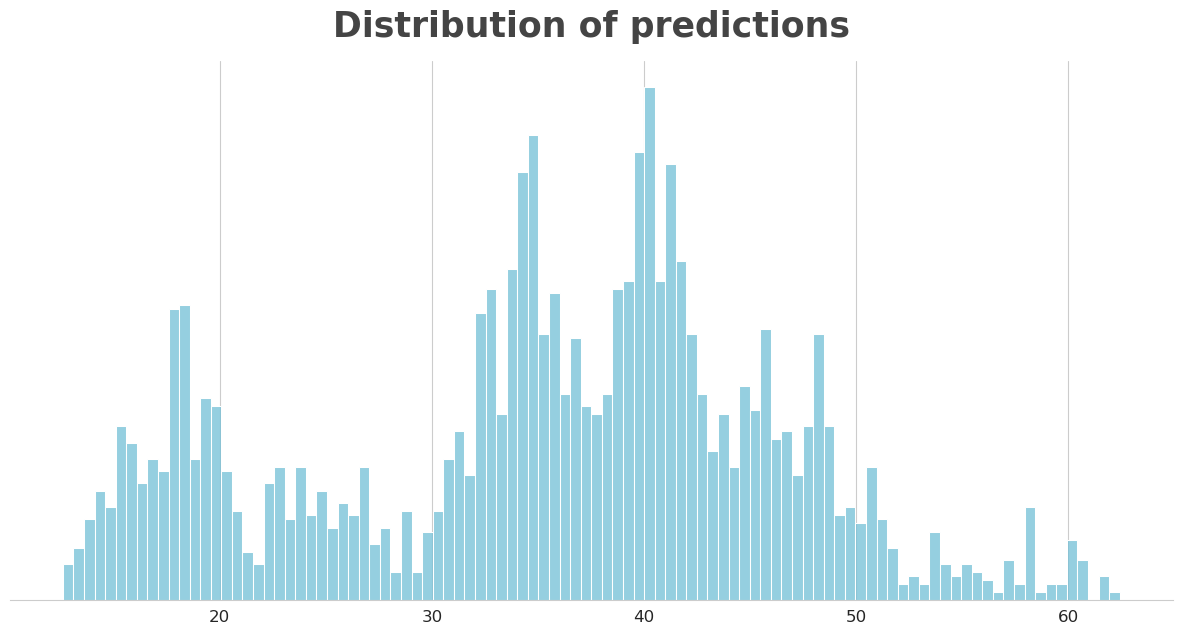

In [31]:
preds_plot(predCB)

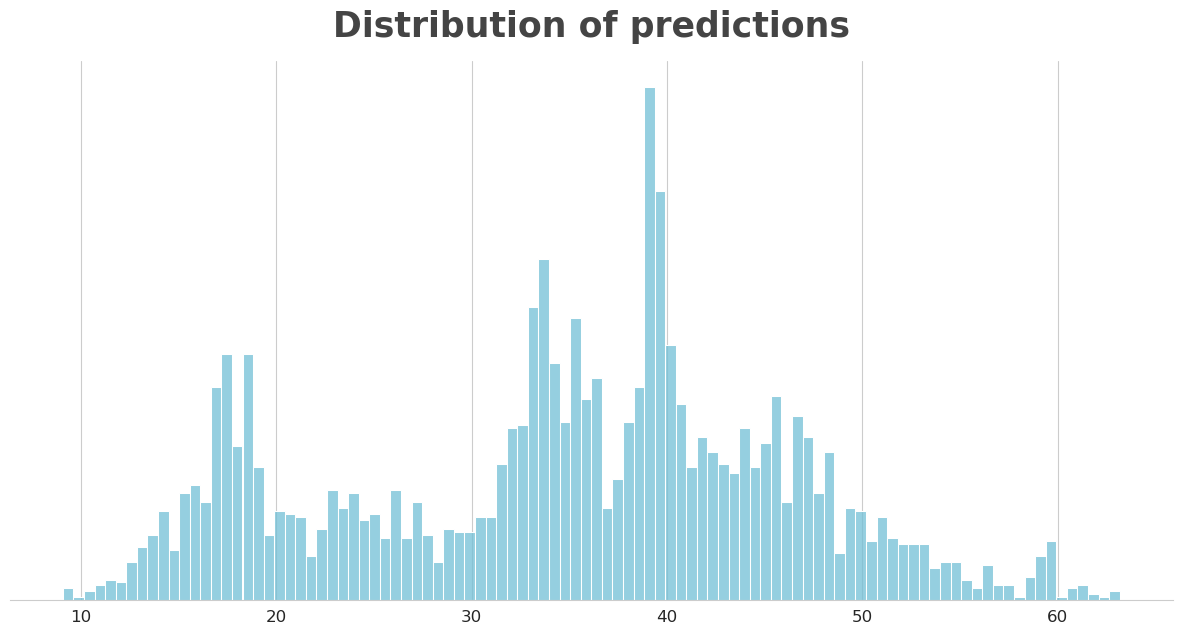

In [32]:
preds_plot(predXB)

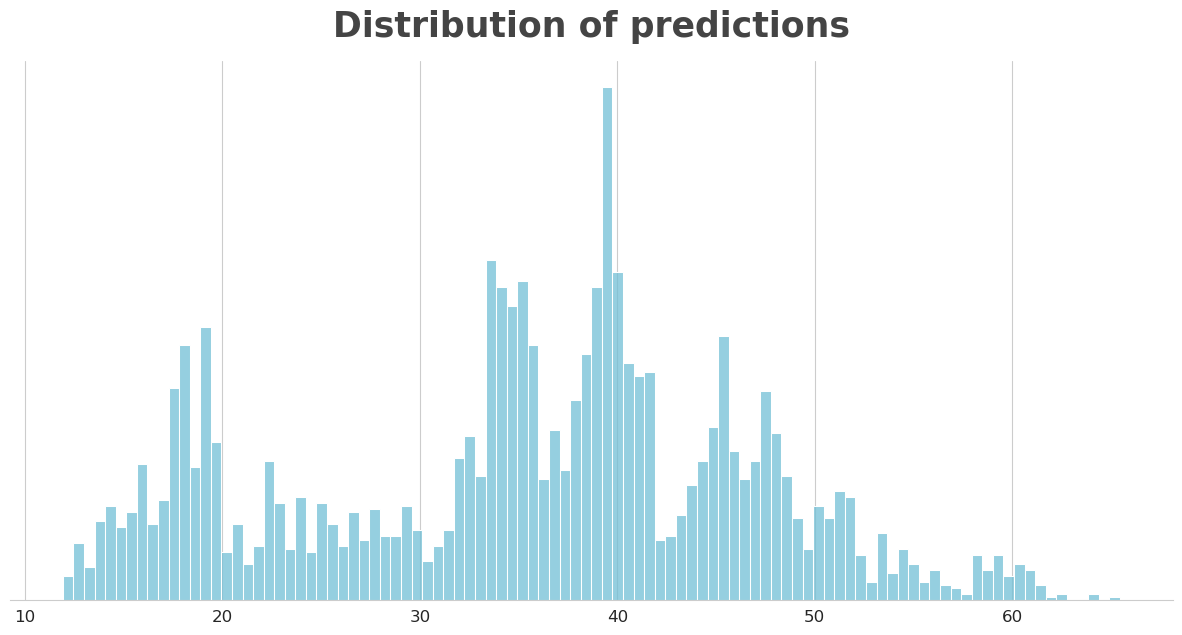

In [33]:
preds_plot(predLB)

In [34]:
pred = predCB * a + predXB * b + predLB * c #+pred_NN * d

In [35]:
submission['Strength'] = pred

In [36]:
submission = submission[['id','Strength']]
submission

,id,Strength
0,5407,47.659053
1,5408,19.380024
2,5409,32.433072
3,5410,46.734594
4,5411,27.803391
...,...,...
3600,9007,32.137445
3601,9008,35.056430
3602,9009,39.859014
3603,9010,35.772507


In [37]:
submission.to_csv("submission.csv",index=False)
submission

,id,Strength
0,5407,47.659053
1,5408,19.380024
2,5409,32.433072
3,5410,46.734594
4,5411,27.803391
...,...,...
3600,9007,32.137445
3601,9008,35.056430
3602,9009,39.859014
3603,9010,35.772507
